In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Temperature/Sylhet.csv')
#the daily dataset
print(df.shape)
df.head()

(696, 4)


,DATE,Max Temp,Min Temp,MEAN
0,1/31/1956,25.8,12.4,19.1
1,2/29/1956,29.0,14.2,21.6
2,3/31/1956,32.9,18.1,25.5
3,4/30/1956,35.8,21.4,28.6
4,5/31/1956,35.0,23.4,29.2


In [4]:
#checking types
df.pop('Max Temp')
df.pop('Min Temp')
df.dtypes

DATE     object
MEAN    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

           DATE   MEAN
0     1/31/1956  19.10
1     2/29/1956  21.60
2     3/31/1956  25.50
3     4/30/1956  28.60
4     5/31/1956  29.20
..          ...    ...
691   8/31/2013  30.45
692   9/30/2013  30.95
693  10/31/2013  29.05
694  11/30/2013  24.95
695  12/31/2013  22.65

[696 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,DATE,MEAN
0,1/31/1956,19.1
1,2/29/1956,21.6
2,3/31/1956,25.5
3,4/30/1956,28.6
4,5/31/1956,29.2


In [8]:
df.tail()

,DATE,MEAN
691,8/31/2013,30.45
692,9/30/2013,30.95
693,10/31/2013,29.05
694,11/30/2013,24.95
695,12/31/2013,22.65


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
#df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,MEAN
DATE,
1/31/1956,19.1
2/29/1956,21.6
3/31/1956,25.5
4/30/1956,28.6
5/31/1956,29.2


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Sylhet_monthly.csv")

(696, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1956-01-31 00:00:00
End Date: 2013-12-31 00:00:00
Total month: 696
Total year: 58


Data Visulalization
----------

About Data

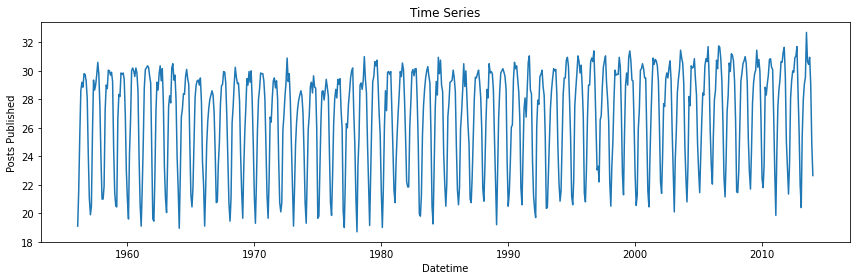

In [12]:
# 7.Plotting the time series
monthly['MEAN'] = monthly['MEAN'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(600, 1), Validation=(96, 1)


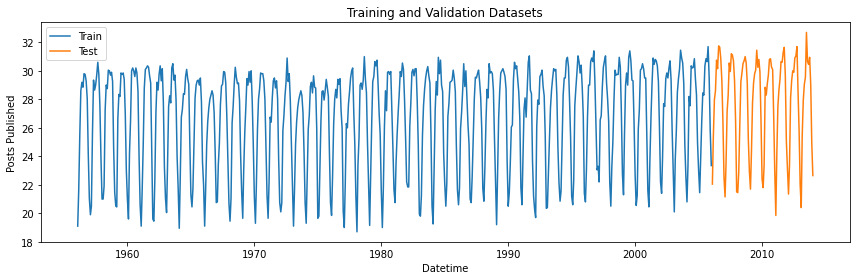

In [13]:
train = monthly.loc[:'2005-12-31']
valid = monthly.loc['2006-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

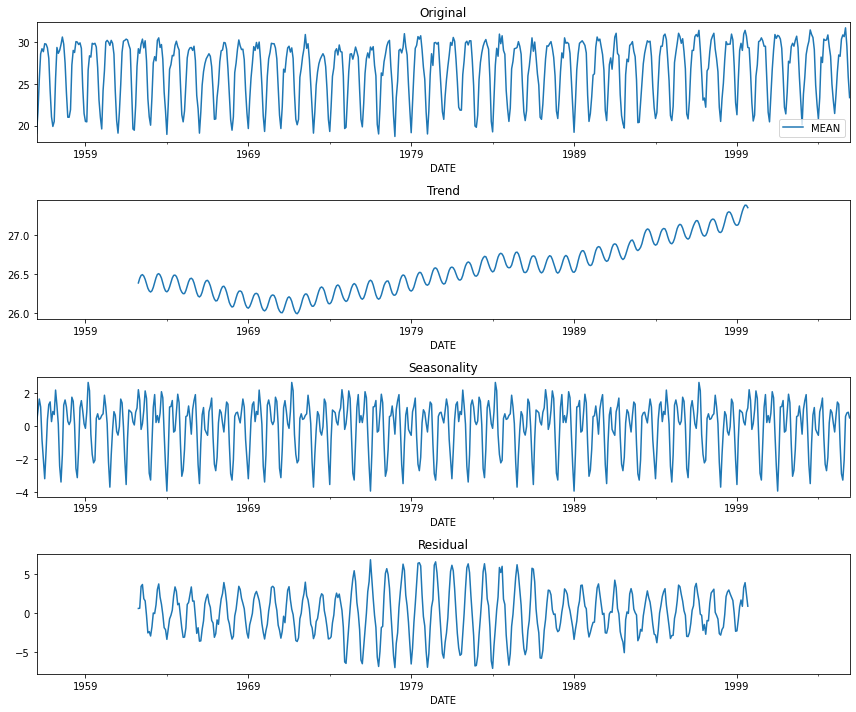

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

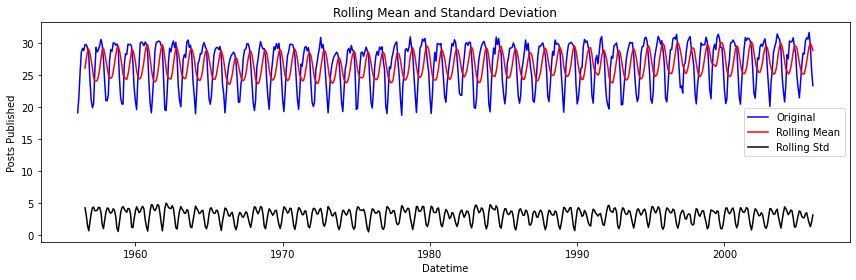

Results of Dickey-Fuller Test:
Test Statistic                  -3.066964
P-Value                          0.029097
#Lags Used                      15.000000
Number of Observations Used    584.000000
Critical Value (1%)             -3.441597
Critical Value (5%)             -2.866502
Critical Value (10%)            -2.569412
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MEAN   No. Observations:                  600
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -967.790
Date:                Mon, 07 Nov 2022   AIC                           1953.579
Time:                        12:41:10   BIC                           1993.137
Sample:                    01-31-1956   HQIC                          1968.979
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8101      0.039     20.952      0.000       0.734       0.886
ar.L2         -0.3117      0.053     -5.926      0.000      -0.415      -0.209
ar.L3         -0.2526      0.057     -4.457      0.0

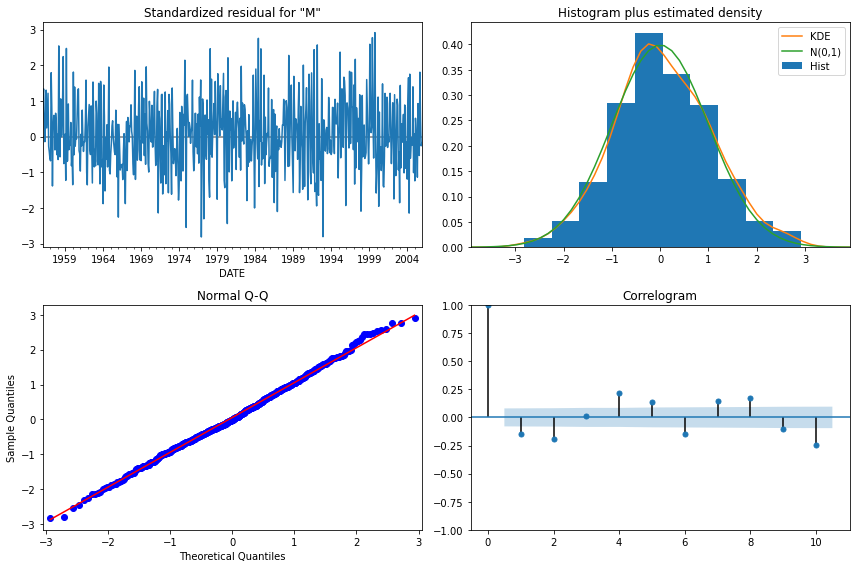

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

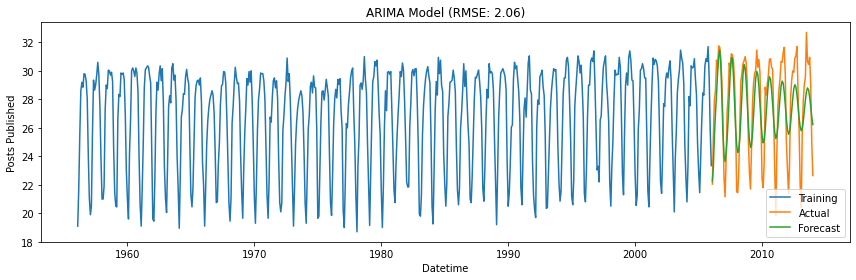

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2006-01-31    22.262272
2006-02-28    23.249494
2006-03-31    25.443481
2006-04-30    26.983188
2006-05-31    28.356995
                ...    
2013-08-31    28.658615
2013-09-30    28.172879
2013-10-31    27.479757
2013-11-30    26.769391
2013-12-31    26.231420
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.0566863303595544


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               MEAN   No. Observations:                  600
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -683.328
Date:                            Mon, 07 Nov 2022   AIC                           1400.657
Time:                                    12:43:36   BIC                           1475.032
Sample:                                01-31-1956   HQIC                          1429.638
                                     - 12-31-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1950      0.047      4.164      0.000       0.103       0.287
ar.L2          0.0419      0.046   

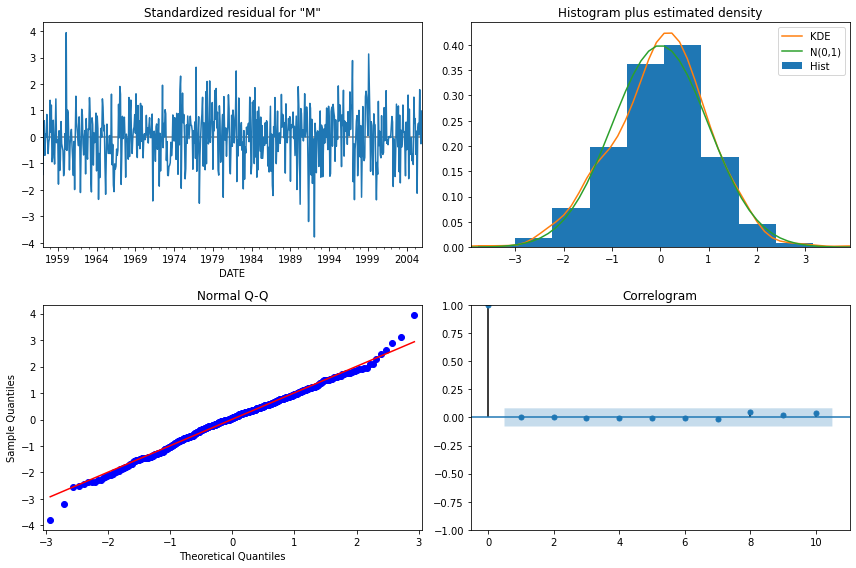

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

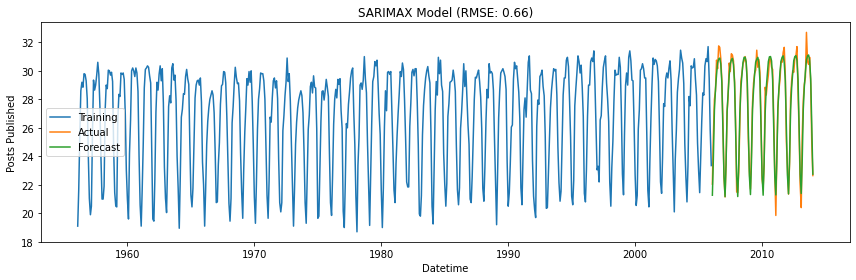

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2006-01-31    21.269395
2006-02-28    23.810830
2006-03-31    27.243195
2006-04-30    28.669368
2006-05-31    29.730598
                ...    
2013-08-31    31.114818
2013-09-30    30.736175
2013-10-31    29.425010
2013-11-30    26.189191
2013-12-31    22.748624
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.6582129629027185


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv('Sylhet_monthly.csv')

In [32]:

#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1956-01-31,19.1
1,1956-02-29,21.6
2,1956-03-31,25.5
3,1956-04-30,28.6
4,1956-05-31,29.2


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysisihri/n4_3tov1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpysisihri/r709l2pj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81670', 'data', 'file=/tmp/tmpysisihri/n4_3tov1.json', 'init=/tmp/tmpysisihri/r709l2pj.json', 'output', 'file=/tmp/tmpysisihri/prophet_model129c073h/prophet_model-20221107124339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 11, freq='M')
print(prophet_forecast_date)

            ds
0   1956-01-31
1   1956-02-29
2   1956-03-31
3   1956-04-30
4   1956-05-31
..         ...
823 2024-08-31
824 2024-09-30
825 2024-10-31
826 2024-11-30
827 2024-12-31

[828 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1956-01-31,26.502140,18.990609,20.902442,26.502140,26.502140,-6.577784,-6.577784,-6.577784,-6.577784,-6.577784,-6.577784,0.0,0.0,0.0,19.924357
1,1956-02-29,26.500015,21.231652,23.178427,26.500015,26.500015,-4.265283,-4.265283,-4.265283,-4.265283,-4.265283,-4.265283,0.0,0.0,0.0,22.234731
2,1956-03-31,26.497743,25.232920,27.108064,26.497743,26.497743,-0.300414,-0.300414,-0.300414,-0.300414,-0.300414,-0.300414,0.0,0.0,0.0,26.197329
3,1956-04-30,26.495545,27.073461,28.940606,26.495545,26.495545,1.504312,1.504312,1.504312,1.504312,1.504312,1.504312,0.0,0.0,0.0,27.999857
4,1956-05-31,26.493273,27.980744,29.737741,26.493273,26.493273,2.363010,2.363010,2.363010,2.363010,2.363010,2.363010,0.0,0.0,0.0,28.856283


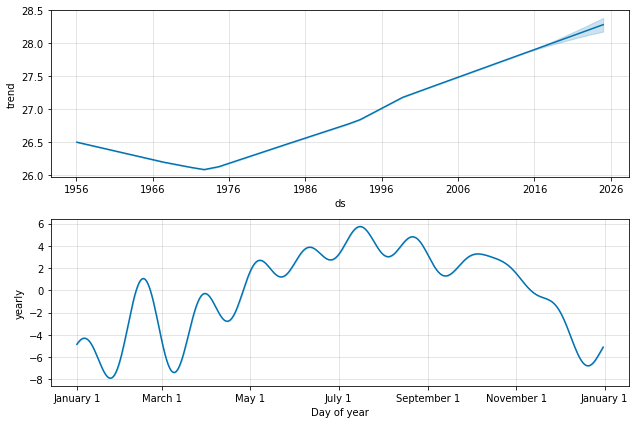

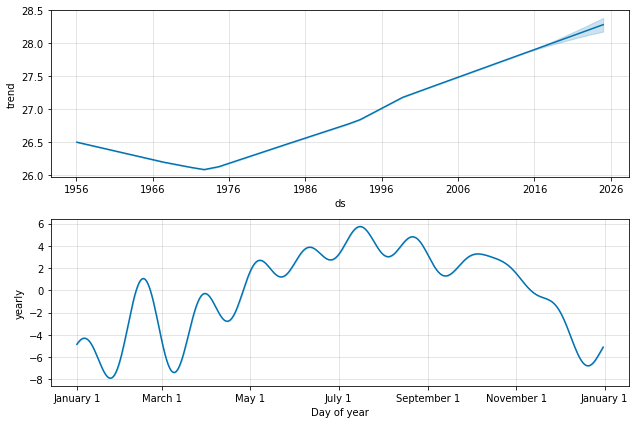

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1956-01-31  19.924357
1956-02-29  22.234731
1956-03-31  26.197329
1956-04-30  27.999857
1956-05-31  28.856283
...               ...
2024-08-31  31.583540
2024-09-30  31.376904
2024-10-31  29.883054
2024-11-30  26.545258
2024-12-31  23.223450

[828 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1956-01-31    19.924357
1956-02-29    22.234731
1956-03-31    26.197329
1956-04-30    27.999857
1956-05-31    28.856283
                ...    
2024-08-31    31.583540
2024-09-30    31.376904
2024-10-31    29.883054
2024-11-30    26.545258
2024-12-31    23.223450
Name: yhat, Length: 828, dtype: float64


In [40]:
print(valid)

             MEAN
DATE             
2006-01-31  22.05
2006-02-28  25.40
2006-03-31  28.00
2006-04-30  28.60
2006-05-31  30.75
...           ...
2013-08-31  30.45
2013-09-30  30.95
2013-10-31  29.05
2013-11-30  24.95
2013-12-31  22.65

[96 rows x 1 columns]


In [41]:
forecast_prophet_valid=full_forecast_prophet['2006-01-31':'2013-12-31']

In [42]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.6507446902135049


-----------------

MODEL Comparison
----------

Testing

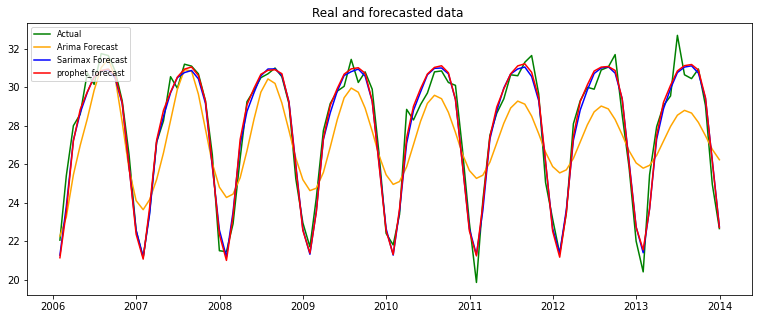

In [43]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

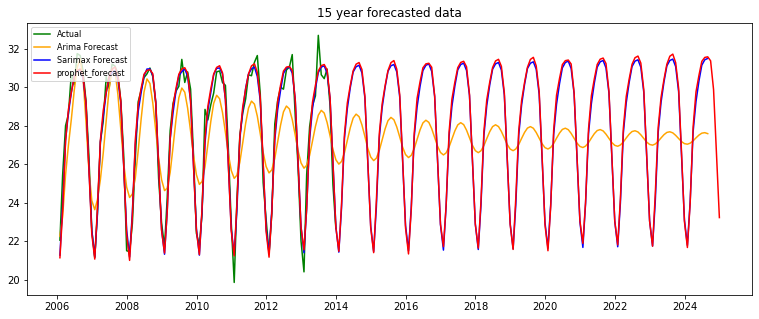

In [44]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+128)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+128)
forecast_10_prophet=full_forecast_prophet['2006-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

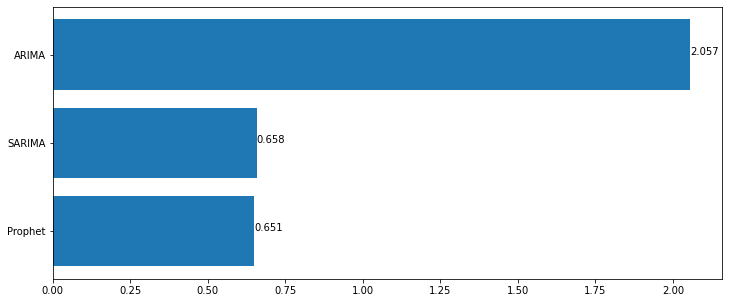

In [45]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [46]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2017-04-30

Great! Now choose the model result you want to see for 2017-04-30
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2017-04-30 rainfall value for Sarimax model:  29.011922125548885


In [47]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Sylhet-monthly_merged.csv")